In [18]:
import cv2
import numpy as np
import onnxruntime as ort
from collections import deque
from modelArc import CRNN
from itertools import groupby
from matplotlib import pyplot as plt

In [13]:
model_path = r"D:\Projects\reciept-scanner\RCNN\models\202407310100\model.onnx"

class inferencemode:
    def __init__(self, model_path: str = ""):
        self.model_path = model_path.replace("\\", "/")
        providers = ["CUDAExecutionProvider", "CPUExecutionProvider"] if ort.get_device() == "GPU" else ["CPUExecutionProvider"]

        self.model = ort.InferenceSession(model_path, providers = providers)

        self.metadata = {}
        for key, value in self.model.get_modelmeta().custom_metadata_map.items():
            new_value = value
            self.metadata[key] = new_value

        self.input_shapes = [meta.shape for meta in self.model.get_inputs()]
        self.input_names = [meta.name for meta in self.model._inputs_meta]
        self.output_names = [meta.name for meta in self.model._outputs_meta]

    def predict(self, image: np.ndarray):
        image = cv2.resize(image, (128, 32))

        image_pred = np.expand_dims(image, axis=0).astype(np.float32)

        preds = self.model.run(self.output_names, {self.input_names[0]: image_pred})[0]

        #highest prob
        argmax_preds = np.argmax(preds, axis=-1)
        grouped_preds = [[k for k,_ in groupby(preds)] for preds in argmax_preds]
        texts = ["".join([self.metadata["vocab"][k] for k in group if k < len(self.metadata["vocab"])]) for group in grouped_preds]
        text = texts[0]

        return text

In [16]:
img_path = r"D:\photos\RCNN4\BBOXES\75.jpg"
#"D:\photos\SORIE\test\0afc0804-7e6e-4e77-ab68-8d9384918be7.jpg"

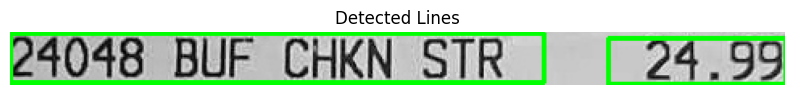

Prediction is: 81  SA SR
Prediction is: 244.99


In [44]:
img_path = r"D:\photos\RCNN4\BBOXES\78.jpg"
image = cv2.imread(img_path.replace("\\", "/"), cv2.IMREAD_GRAYSCALE)

_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

kernel = np.ones((5, 50), np.uint8)

dilated_image = cv2.dilate(binary_image, kernel, iterations=1)

contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_contour_area = 1000
filtered_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

bounding_boxes = [cv2.boundingRect(c) for c in filtered_contours]
bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])

elements = []
color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for i, (x, y, w, h) in enumerate(bounding_boxes):
    if w > 20 and h>25:
        line_image = color_image[y:y+h, x:x+w]
        elements.append(line_image)

model = inferencemode(model_path)
for (x, y, w, h) in bounding_boxes:
    if w > 20 and h>25:
        cv2.rectangle(color_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
# Plot the image with bounding boxes
plt.figure(figsize=(10, 2))
plt.imshow(color_image, cmap='gray')
plt.title('Detected Lines')
plt.axis('off')
plt.show()

for capture in elements:
    prediction_text = model.predict(capture)
    print(f"Prediction is: {prediction_text}")